# Data Exploratory Analysis (EDA)

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load merged cycles
df = pd.read_csv("../data/processed/hydraulic_cycles.csv")

# define sensor groups and their prefixes
sensor_groups = {
    "PS":   [f"PS{i}" for i in range(1,7)],
    "EPS1": ["EPS1"],
    "FS":   ["FS1","FS2"],
    "LOW":  ["TS1","TS2","TS3","TS4","VS1","CE","CP","SE"]
}

# compute summary stats for each sensor prefix
for group, prefixes in sensor_groups.items():
    for p in prefixes:
        cols = [c for c in df.columns if c.startswith(p + "_")]
        df[f"{p}_mean"] = df[cols].mean(axis=1)
        df[f"{p}_std"]  = df[cols].std(axis=1)
        df[f"{p}_min"]  = df[cols].min(axis=1)
        df[f"{p}_max"]  = df[cols].max(axis=1)

# collect only the newly created summary features
summary_cols = [c for c in df.columns if any(s in c for s in ["_mean","_std","_min","_max"])]



## Univariate Analysis
### 1. Countplots for Each Target

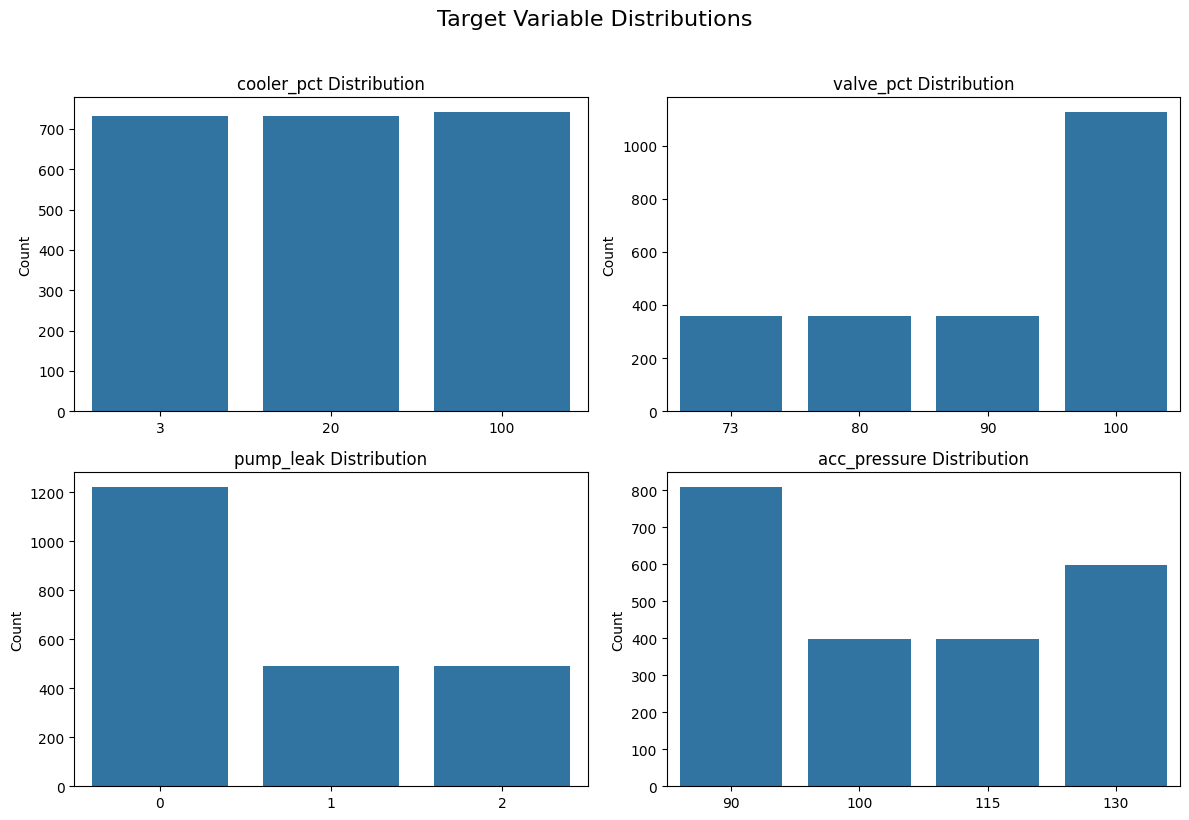

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

targets = ["cooler_pct", "valve_pct", "pump_leak", "acc_pressure"]
for ax, target in zip(axes.flat, targets):
    sns.countplot(x=target, data=df, ax=ax)
    ax.set_title(f"{target} Distribution")
    ax.set_xlabel("")
    ax.set_ylabel("Count")

plt.suptitle("Target Variable Distributions", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


### 2. Summary-Stat Distributions

#### 2.1 Descriptive Statistics Table
A quick `.describe()` on our newly computed features to spot scale differences.


In [ ]:
desc = df[summary_cols].describe().T
# display top 8 rows for brevity
desc.head(10)

,PS1_mean,PS1_std,PS1_min,PS1_max,PS2_mean,PS2_std,PS2_min,PS2_max,PS3_mean,PS3_std,...,CE_min,CE_max,CP_mean,CP_std,CP_min,CP_max,SE_mean,SE_std,SE_min,SE_max
0,160.673492,13.939309,145.83,191.51,109.466914,47.114508,0.0,156.99,1.991475,0.945705,...,28.866,47.438,1.862750,0.279385,1.383,2.188,59.157183,23.763984,0.0,79.568
1,160.603320,14.118967,145.73,191.47,109.354890,47.045611,0.0,157.56,1.976234,0.941967,...,23.320,29.208,1.255550,0.074605,1.147,1.414,59.335617,23.857918,0.0,80.441
2,160.347720,14.192619,145.37,191.41,109.158845,46.992060,0.0,156.97,1.972224,0.943501,...,21.220,23.554,1.113217,0.023263,1.076,1.159,59.543150,23.923381,0.0,80.824
3,160.188088,14.227803,145.14,191.34,109.064807,46.972221,0.0,156.44,1.946575,0.935534,...,19.673,21.565,1.062150,0.024621,1.022,1.107,59.794900,24.023005,0.0,80.930
4,160.000472,14.276434,144.95,191.41,108.931434,46.874946,0.0,158.13,1.922707,0.930335,...,19.133,20.460,1.070467,0.021477,1.016,1.106,59.455267,23.972262,0.0,81.100


#### 2.2 Histograms with KDE
Loop over a few representative features—means and stddevs—to see their shapes.


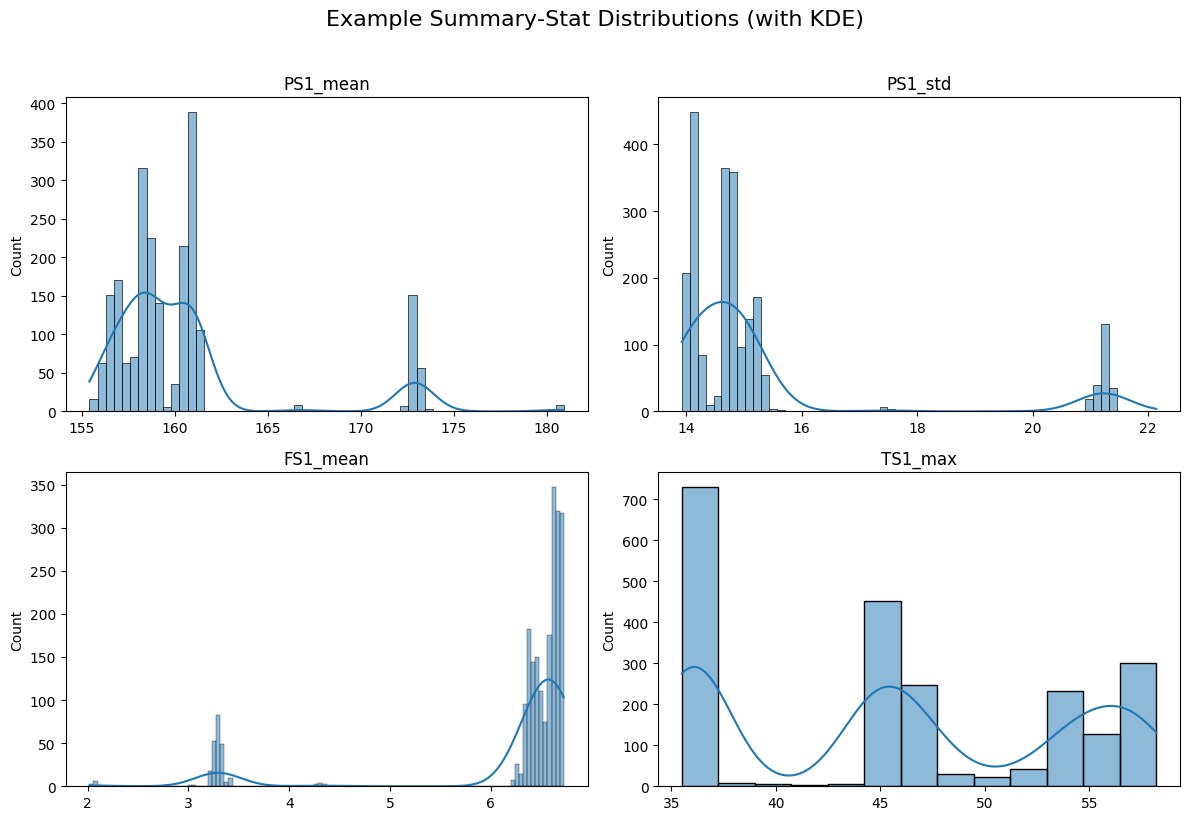

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# pick one representative feature per group (must match actual columns in df)
examples = ["PS1_mean", "PS1_std", "FS1_mean", "TS1_max"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, feat in zip(axes.flat, examples):
    sns.histplot(df[feat], ax=ax, kde=True)
    ax.set_title(feat)
    ax.set_xlabel("")
plt.suptitle("Example Summary‑Stat Distributions (with KDE)", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


#### 2.3 Boxplots for Outlier Detection
Visualize spread and outliers for the same features.

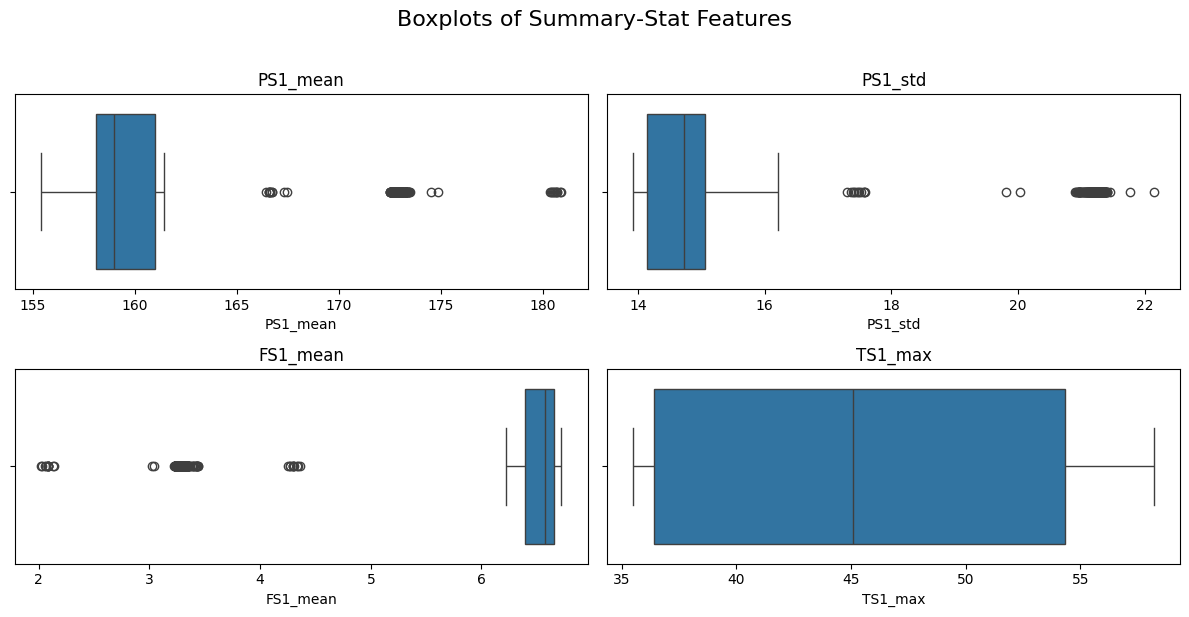

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for ax, feat in zip(axes.flat, examples):
    sns.boxplot(x=df[feat], ax=ax)
    ax.set_title(feat)
plt.suptitle("Boxplots of Summary‑Stat Features", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

## Bivariate Analysis

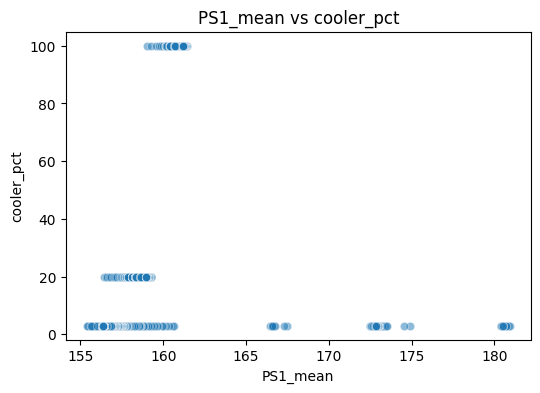

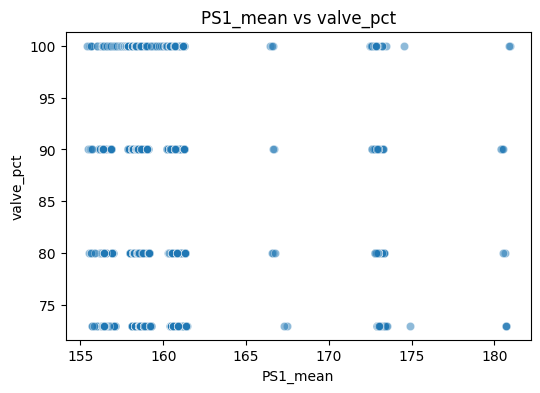

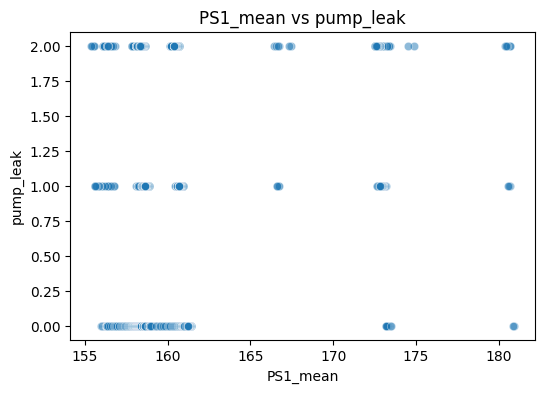

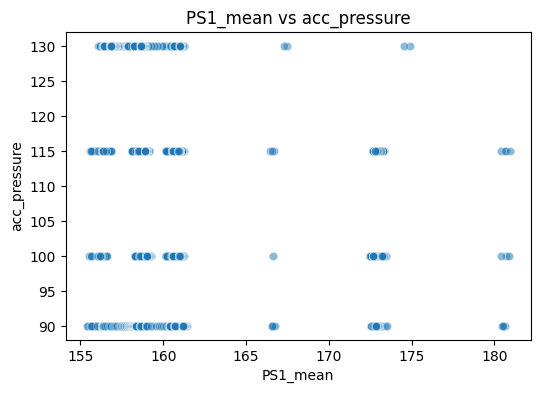

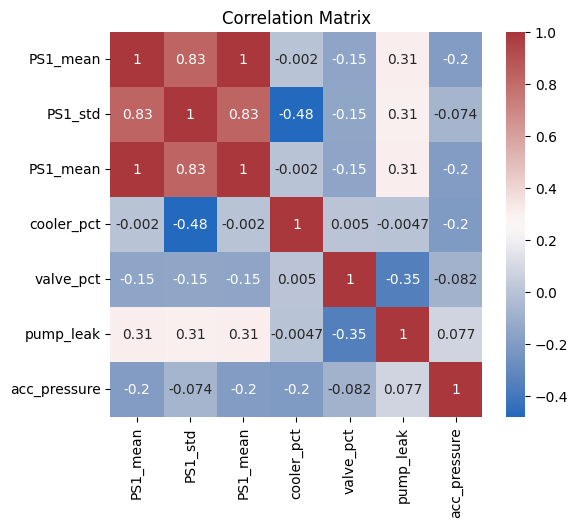

In [9]:
# --- Bivariate Analysis ---

# 3. Sensor vs. each target
for tgt in ["cooler_pct","valve_pct","pump_leak","acc_pressure"]:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x="PS1_mean", y=tgt, data=df, alpha=0.5)
    plt.title(f"PS1_mean vs {tgt}")
    plt.show()

# 4. Correlation heatmap between summary stats and targets
stats = df[["PS1_mean","PS1_std","PS1_mean","cooler_pct","valve_pct","pump_leak","acc_pressure"]]
corr = stats.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="vlag")
plt.title("Correlation Matrix"); plt.show()